In [2]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal.windows import dpss

## 0. Load Data

In [58]:
EEG = scipy.io.loadmat("../../data/sampleEEGdata.mat")['EEG'][0, 0]
eegData = EEG['data']
eegTimes = EEG['times']
eegSrate = EEG['srate']
eegChanLabels = EEG['chanlocs'][0]['labels']

## Figure 16.1

In [121]:
channel2plot = 'o1'
timewin = 400 # ms

pts_in_win = int(np.round((timewin/1000)*eegSrate))
tapers = dpss(pts_in_win, NW=5, Kmax=5)

eegChanLabels == channel2plot.upper()
d = np.squeeze(sig.detrend(eegData[eegChanLabels == channel2plot.upper(), 
                        200 - 1:200 - 1 + pts_in_win, 9]))

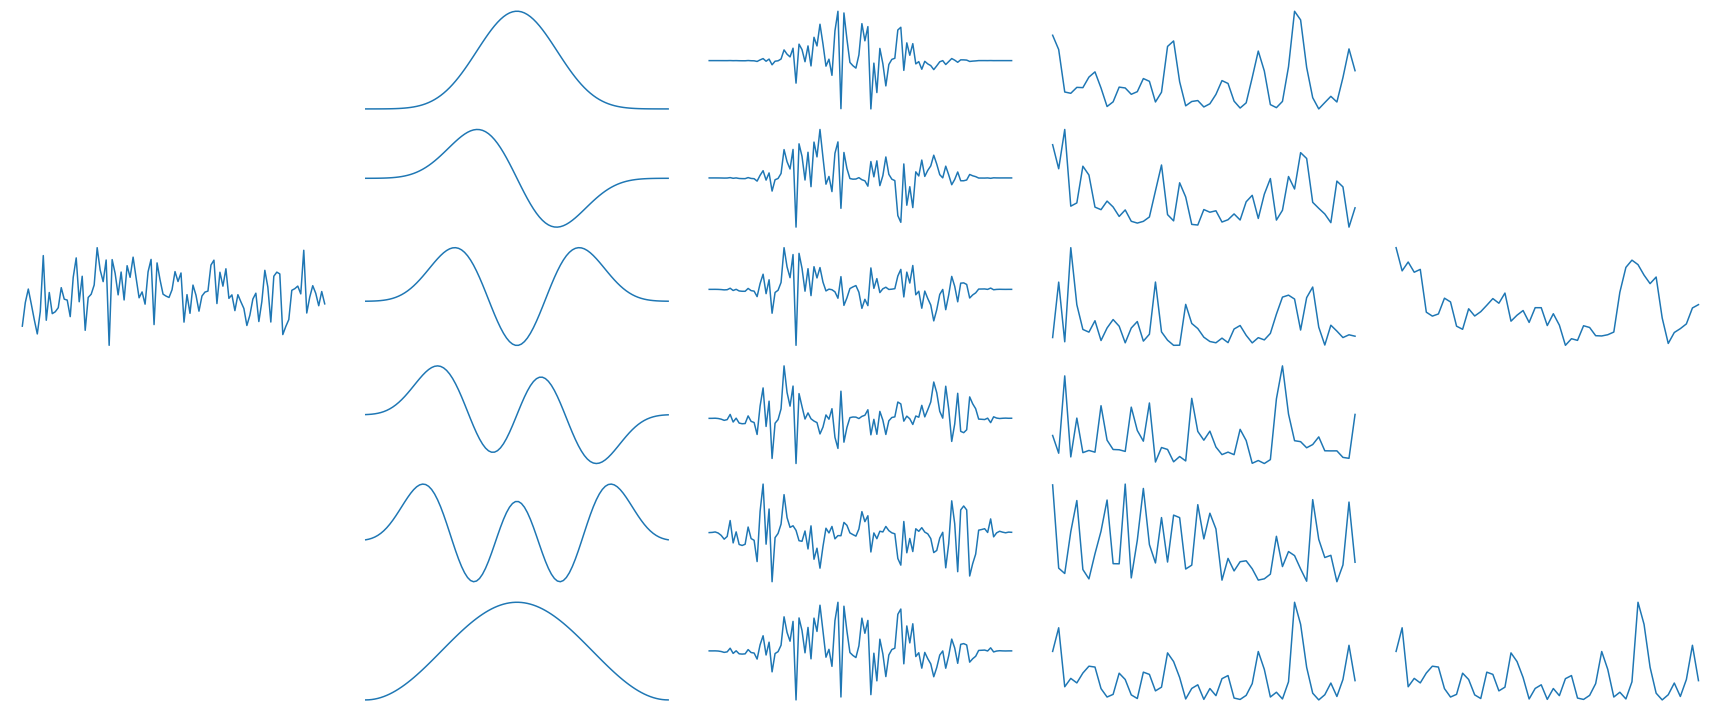

In [135]:
fig, subplot_arr = plt.subplots(6,5,figsize=(24,10))
for ri in range(6):
    for ci in range(5):
        subplot_arr[ri, ci].axis('off')
        
# time series data        
plt.subplot(6, 5, 11)
plt.plot(d)
plt.axis('off')
# tapers
for ti in range(5):
    plt.subplot(6,5,(5 * ti)+2)
    plt.plot(tapers[ti, :])
    plt.axis('off')
# data * tapers
for ti in range(5):
    plt.subplot(6, 5, (5 * ti) + 3)
    plt.plot(tapers[ti, :] * d)
    plt.axis("off")
# power spectra
fft_res = np.zeros((5, pts_in_win)) * 1j
for ti in range(5):
    plt.subplot(6, 5, (5 * ti) + 4)
    fft_res[ti, :] = fft(tapers[ti, :] * d)
    plt.plot(np.absolute(fft_res[ti, :int(pts_in_win/2)])**2)
    plt.axis("off")  
# average spectra
plt.subplot(6, 5, 15)
plt.plot(np.mean(np.absolute(fft_res[:, :int(pts_in_win/2)])**2, axis=0))
plt.axis("off")  


# STFFT res
plt.subplot(6, 5, 27)
hann = 0.5 * (1 - np.cos(2 * np.pi * np.arange(pts_in_win)/(pts_in_win - 1)))
plt.plot(hann)
plt.axis("off")  

plt.subplot(6, 5, 28)
hann_res = hann * d
plt.plot(hann_res)
plt.axis("off")  

plt.subplot(6, 5, 29)
hann_fft = fft(hann_res)
plt.plot(np.absolute(hann_fft[:int(pts_in_win/2)])**2)
plt.axis("off")  

plt.subplot(6, 5, 30)
plt.plot(np.absolute(hann_fft[:int(pts_in_win/2)])**2)
plt.axis("off")  
plt.tight_layout()

## Figure 16.2

In [176]:
channel2plot = 'p7'
frequency2plot = 15 # Hz
timepoint2plot = 200 # ms

nw_product = 3 # determines the frequency smoothing, given a specified time window
times2save = np.arange(-300, 1000 + 50, 50)
baseline_range = np.array([-200, 0])
timewin = 400 # ms

times2saveidx = [np.argmin(np.abs(eegTimes - t)) for t in times2save]
pts_in_win = int(np.round((timewin/1000) * eegSrate))

baseidx = np.zeros_like(baseline_range)
baseidx[0] = np.argmin(np.abs(times2save - baseline_range[0]))
baseidx[1] = np.argmin(np.abs(times2save - baseline_range[1]))

tapers = dpss(pts_in_win, NW=nw_product, Kmax=6)
f = np.linspace(0, eegSrate/2, (pts_in_win//2) + 1)

chanidx = (eegChanLabels == channel2plot.upper())

multitaper_tf = np.zeros(((len(f), len(times2saveidx))))

In [223]:
# bugs to be fixed
for ti in range(len(times2saveidx)):
    taperpow = np.zeros((len(f))) * 1j
    start_idx = int(times2saveidx[ti] - np.floor(pts_in_win/2))
    end_idx = int(times2saveidx[ti] + np.ceil(pts_in_win/2))
    for tapi in range(0, tapers.shape[0]-1):
        data = np.squeeze(eegData[chanidx, start_idx:end_idx, :]) 
                    * np.reshape(tapers[tapi, :], (pts_in_win, 1))
        power = fft(data, n=pts_in_win, axis=0)/pts_in_win
        power = power[:int(np.floor(pts_in_win/2)+1), :]
        taperpow = taperpow + np.mean(power * np.conj(power), 1)
    
    multitaper_tf[:, ti] = np.real(taperpow/(tapers.shape[0]-1))

db_multitaper_tf = 10 * np.log10( multitaper_tf / 
                                 np.tile(
                                     np.mean(multitaper_tf[:, int(baseidx[0]):int(baseidx[1])], axis=1),
                                     [len(times2save),1]).T
                                )

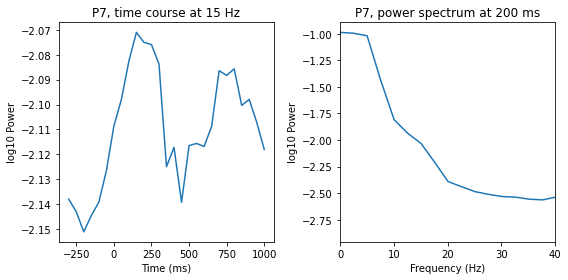

In [250]:
fig, subplot_arr = plt.subplots(1,2,figsize=(8,4))

plt.subplot(1, 2, 1)
freq2plotidx = np.argmin(np.absolute(f - frequency2plot))
# a:b range from a to b - 1
plt.plot(times2save, np.mean(np.log10(multitaper_tf[freq2plotidx-2:freq2plotidx+3, :]), axis=0))
plt.title(channel2plot.upper() + ", time course at " + str(frequency2plot) + " Hz")
plt.xlabel('Time (ms)')
plt.ylabel('log10 Power')

plt.subplot(1, 2, 2)
time2plotidx = np.argmin(np.absolute(times2save - timepoint2plot))
# a:b range from a to b - 1
plt.plot(np.squeeze(f), np.log10(multitaper_tf[:, time2plotidx]))
plt.title(channel2plot.upper() + ", power spectrum at " + str(timepoint2plot) + " ms")
plt.xlabel('Frequency (Hz)')
plt.ylabel('log10 Power')
plt.setp(plt.gca(),'xlim',[f[0], 40])
plt.tight_layout()

## Full TF map

Text(0.5, 1.0, 'Power via multitaper from channel P7')

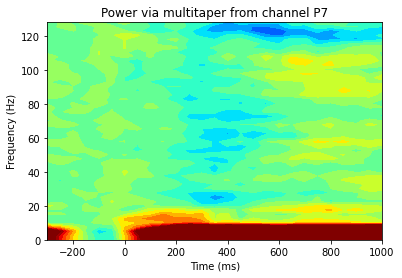

In [256]:
plt.contourf(times2save, np.squeeze(f), db_multitaper_tf, 40, cmap=plt.cm.jet)
plt.clim([-2, 2])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Power via multitaper from channel ' + channel2plot.upper())